# Data Understanding & Loading

In [1]:
import pandas as pd
import numpy as np
import sqlite3

# Load Excel
users = pd.read_csv("users.csv")

# Load JSON
sales = pd.read_json("sales.json")

# Load SQL
conn = sqlite3.connect(":memory:")
with open("inventory.sql", "r", encoding="utf-8", errors="ignore") as f:
    conn.executescript(f.read())

tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
inventory = pd.read_sql(f"SELECT * FROM {tables.iloc[0,0]}", conn)

# Preview
display(users.head(), sales.head(), inventory.head())

# Info
users.info()
sales.info()
inventory.info()


,user_id,name,age,gender,city,registration_date
0,U0001,Vihaan Sharma,35.0,Other,Jaipur,2022-09-08
1,U0002,NaN,30.0,Other,Hyderabad,2023-11-24
2,U0003,NaN,NaN,Other,Indore,2022-02-02
3,U0004,Aarav Gupta,44.0,Male,Kolkata,2023-06-02
4,U0005,Sara Sharma,30.0,NaN,Chennai,2024-01-04


,transaction_id,user_id,product_id,amount,payment_type,date
0,T000001,U0024,P015,67.67,Wallet,2023-02-12
1,T000002,U0196,P044,76.44,UPI,2023-03-24
2,T000003,U0196,P049,104.57,Debit Card,2025-08-21
3,T000004,U0133,P042,102.75,Net Banking,2024-07-23
4,T000005,U0047,P038,23.89,Net Banking,2025-10-04


,product_id,product_name,category,price,stock
0,P001,Product_001,Grocery,264.89,371
1,P002,Product_002,Grocery,605.91,150
2,P003,Product_003,Beauty,3027.98,127
3,P004,Product_004,Toys,2600.12,229
4,P005,Product_005,Books,1178.99,18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            200 non-null    object 
 1   name               178 non-null    object 
 2   age                179 non-null    float64
 3   gender             175 non-null    object 
 4   city               180 non-null    object 
 5   registration_date  184 non-null    object 
dtypes: float64(1), object(5)
memory usage: 9.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1000 non-null   object        
 1   user_id         1000 non-null   object        
 2   product_id      1000 non-null   object        
 3   amount          1000 non-null   float64       
 4   payment_type    1000 non-null   object

In [2]:
users.isnull().sum()

user_id               0
name                 22
age                  21
gender               25
city                 20
registration_date    16
dtype: int64

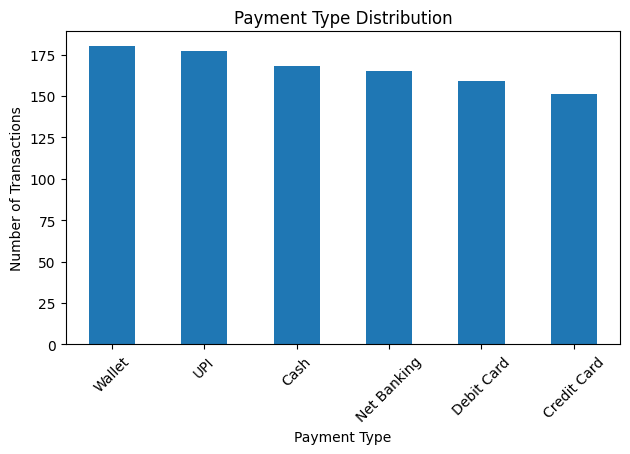

In [3]:

import matplotlib.pyplot as plt
payment_counts = sales['payment_type'].value_counts()

plt.figure()
payment_counts.plot(kind='bar')
plt.title('Payment Type Distribution')
plt.xlabel('Payment Type')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

C:\Users\BAPS\AppData\Local\Temp\ipykernel_15680\3526368660.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = sales.resample('M', on='date')['amount'].sum()


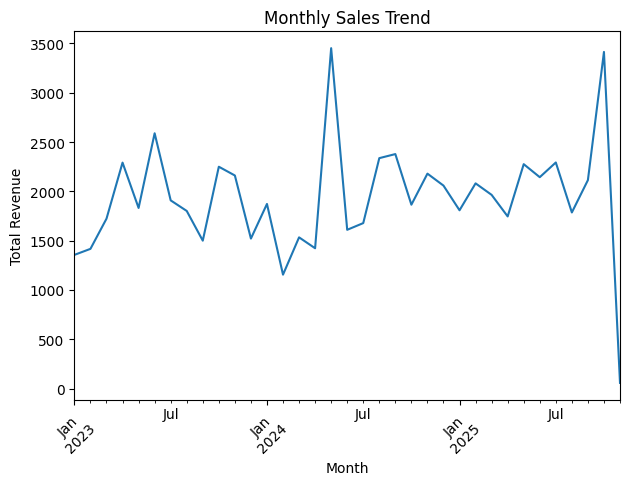

In [4]:
monthly_sales = sales.resample('M', on='date')['amount'].sum()

plt.figure()
monthly_sales.plot()
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

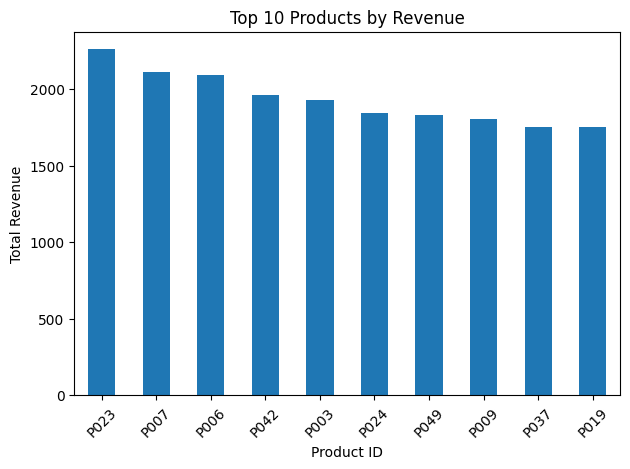

In [5]:
top_products = sales.groupby('product_id')['amount'].sum().sort_values(ascending=False).head(10)

plt.figure()
top_products.plot(kind='bar')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Product ID')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Missing Value Handling

Numerical → Mean

Categorical → Most Frequent

KNN Imputer (multivariate)

In [6]:
from sklearn.impute import SimpleImputer, KNNImputer

num_cols = users.select_dtypes(include=np.number).columns
cat_cols = users.select_dtypes(exclude=np.number).columns

users[num_cols] = SimpleImputer(strategy="mean").fit_transform(users[num_cols])
users[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(users[cat_cols])

sales_numeric = sales.select_dtypes(include=np.number)
sales[sales_numeric.columns] = KNNImputer(n_neighbors=5).fit_transform(sales_numeric)


# Outlier Handling
### Z-Score & IQR Comparison
IQR chosen (robust for skewed business data)

### Winsorization

# Data Transformation

### Date Features

In [7]:
sales["date"] = pd.to_datetime(sales["date"], errors="coerce")
sales["day"] = sales["date"].dt.day
sales["month"] = sales["date"].dt.month
sales["year"] = sales["date"].dt.year


### Encoding

In [8]:
from sklearn.preprocessing import LabelEncoder

for col in users.select_dtypes(include="object"):
    if users[col].nunique() == 2:
        users[col] = LabelEncoder().fit_transform(users[col])

users = pd.get_dummies(users, drop_first=True)


### Log & √ Transform

In [9]:
sales["log_amount"] = np.log1p(sales["amount"])
sales["sqrt_amount"] = np.sqrt(sales["amount"])


# Feature Scaling

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_std = StandardScaler()
scaler_mm = MinMaxScaler()

sales_std = scaler_std.fit_transform(sales.select_dtypes(include=np.number))
sales_mm = scaler_mm.fit_transform(sales.select_dtypes(include=np.number))


# Feature Construction

In [11]:

print(sales.columns)


Index(['transaction_id', 'user_id', 'product_id', 'amount', 'payment_type',
       'date', 'day', 'month', 'year', 'log_amount', 'sqrt_amount'],
      dtype='object')


In [12]:
customer_col = "user_id"
amount_col = "amount"
date_col = "date"


In [13]:
# Detect possible customer column
possible_customers = ["customer_id", "user_id", "userid", "cust_id"]
possible_amounts = ["amount", "price", "total", "sales"]
possible_dates = ["date", "order_date", "purchase_date"]

def find_col(cols, options):
    for o in options:
        if o in cols:
            return o
    return None

cust_col = find_col(sales.columns, possible_customers)
amt_col = find_col(sales.columns, possible_amounts)
dt_col = find_col(sales.columns, possible_dates)

print("Customer:", cust_col)
print("Amount:", amt_col)
print("Date:", dt_col)


Customer: user_id
Amount: amount
Date: date


In [14]:
features = sales.groupby(cust_col).agg(
    avg_monthly_spend=(amt_col, "mean"),
    purchase_frequency=(amt_col, "count"),
    total_spend=(amt_col, "sum"),
    last_purchase=(dt_col, "max")
).reset_index()

features["days_since_last_purchase"] = (
    pd.Timestamp.today() - pd.to_datetime(features["last_purchase"])
).dt.days

features.head()


,user_id,avg_monthly_spend,purchase_frequency,total_spend,last_purchase,days_since_last_purchase
0,U0001,77.473333,3,232.42,2024-08-20,550
1,U0002,64.840000,6,389.04,2024-04-27,665
2,U0003,40.597500,4,162.39,2025-11-01,112
3,U0004,100.213333,3,300.64,2024-04-03,689
4,U0005,57.948333,6,347.69,2025-06-22,244


In [15]:
print("Users columns:", users.columns.tolist())
print("Features columns:", features.columns.tolist())



Users columns: ['age', 'user_id_U0002', 'user_id_U0003', 'user_id_U0004', 'user_id_U0005', 'user_id_U0006', 'user_id_U0007', 'user_id_U0008', 'user_id_U0009', 'user_id_U0010', 'user_id_U0011', 'user_id_U0012', 'user_id_U0013', 'user_id_U0014', 'user_id_U0015', 'user_id_U0016', 'user_id_U0017', 'user_id_U0018', 'user_id_U0019', 'user_id_U0020', 'user_id_U0021', 'user_id_U0022', 'user_id_U0023', 'user_id_U0024', 'user_id_U0025', 'user_id_U0026', 'user_id_U0027', 'user_id_U0028', 'user_id_U0029', 'user_id_U0030', 'user_id_U0031', 'user_id_U0032', 'user_id_U0033', 'user_id_U0034', 'user_id_U0035', 'user_id_U0036', 'user_id_U0037', 'user_id_U0038', 'user_id_U0039', 'user_id_U0040', 'user_id_U0041', 'user_id_U0042', 'user_id_U0043', 'user_id_U0044', 'user_id_U0045', 'user_id_U0046', 'user_id_U0047', 'user_id_U0048', 'user_id_U0049', 'user_id_U0050', 'user_id_U0051', 'user_id_U0052', 'user_id_U0053', 'user_id_U0054', 'user_id_U0055', 'user_id_U0056', 'user_id_U0057', 'user_id_U0058', 'user_id

In [16]:
common_cols = set(users.columns).intersection(set(features.columns))
print("Common columns:", common_cols)


Common columns: set()


In [17]:
print("Users columns:", users.columns.tolist())
print("Features columns:", features.columns.tolist())


Users columns: ['age', 'user_id_U0002', 'user_id_U0003', 'user_id_U0004', 'user_id_U0005', 'user_id_U0006', 'user_id_U0007', 'user_id_U0008', 'user_id_U0009', 'user_id_U0010', 'user_id_U0011', 'user_id_U0012', 'user_id_U0013', 'user_id_U0014', 'user_id_U0015', 'user_id_U0016', 'user_id_U0017', 'user_id_U0018', 'user_id_U0019', 'user_id_U0020', 'user_id_U0021', 'user_id_U0022', 'user_id_U0023', 'user_id_U0024', 'user_id_U0025', 'user_id_U0026', 'user_id_U0027', 'user_id_U0028', 'user_id_U0029', 'user_id_U0030', 'user_id_U0031', 'user_id_U0032', 'user_id_U0033', 'user_id_U0034', 'user_id_U0035', 'user_id_U0036', 'user_id_U0037', 'user_id_U0038', 'user_id_U0039', 'user_id_U0040', 'user_id_U0041', 'user_id_U0042', 'user_id_U0043', 'user_id_U0044', 'user_id_U0045', 'user_id_U0046', 'user_id_U0047', 'user_id_U0048', 'user_id_U0049', 'user_id_U0050', 'user_id_U0051', 'user_id_U0052', 'user_id_U0053', 'user_id_U0054', 'user_id_U0055', 'user_id_U0056', 'user_id_U0057', 'user_id_U0058', 'user_id

In [18]:
before = sales

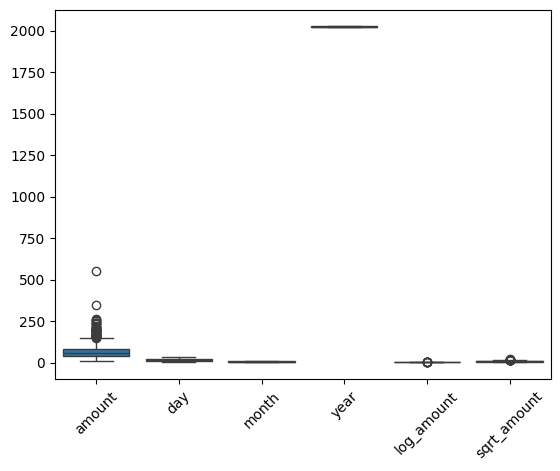

In [19]:
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.boxplot(before)
plt.xticks(rotation=45)
plt.show()

## IQR method

In [20]:
import pandas as pd
import numpy as np

cols = ["amount"]

for col in cols:
    Q1 = sales[col].quantile(0.25)
    Q3 = sales[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_mask = (sales[col] < lower_bound) | (sales[col] > upper_bound)
    median_val = int(np.ceil(sales[col].median()))
    sales.loc[outliers_mask, col] = median_val

print("All outliers filled with median using IQR method.")

All outliers filled with median using IQR method.


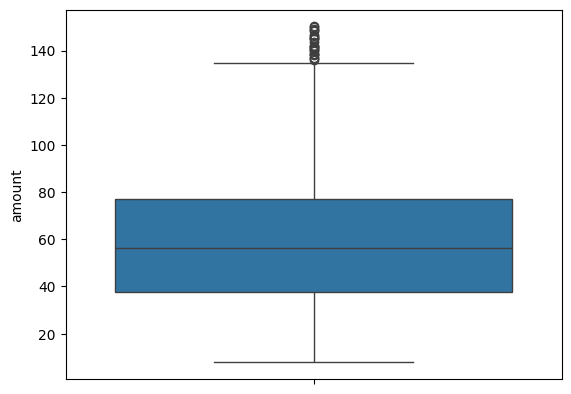

In [21]:
sns.boxplot(sales["amount"])
plt.show()

## winsorization method


In [22]:
from scipy.stats.mstats import winsorize
sales["amount"] = winsorize(sales["amount"],limits=[0.03,0.03])

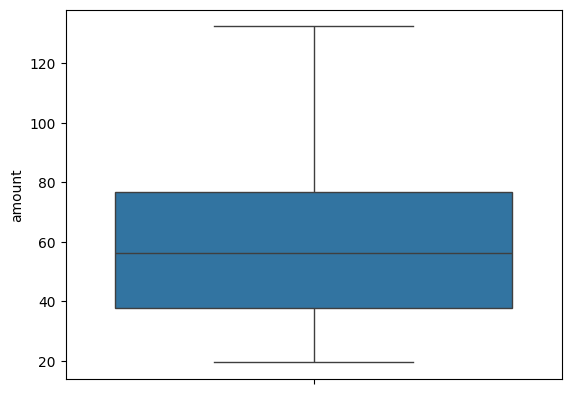

In [23]:
sns.boxplot(sales["amount"])
plt.show()

In [24]:
sales["log_amount"] = winsorize(sales["log_amount"],limits=[0.01,0.01])

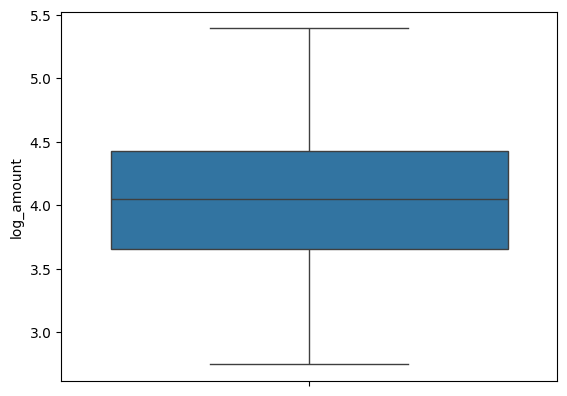

In [25]:
sns.boxplot(sales["log_amount"])
plt.show()

In [26]:
sales["sqrt_amount"] = winsorize(sales["sqrt_amount"],limits=[0.03,0.03])

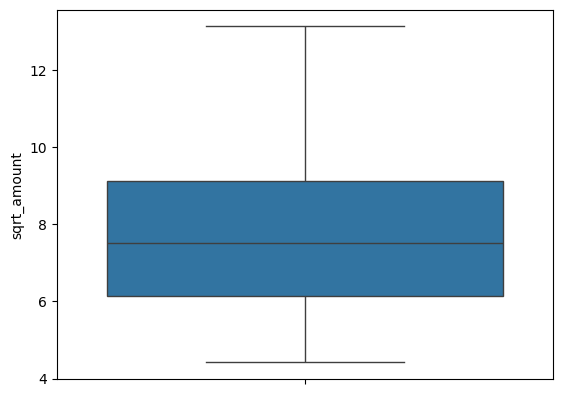

In [27]:
sns.boxplot(sales["sqrt_amount"])
plt.show()

In [28]:
after = sales

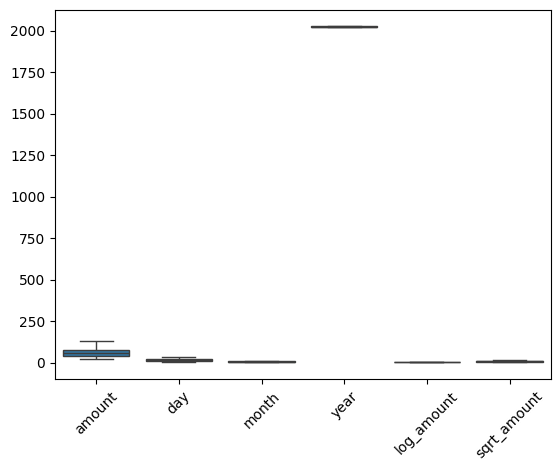

In [29]:
sns.boxplot(sales)
plt.xticks(rotation=45)
plt.show()

# Final Dataset Preparation

## Outliers before Vs After

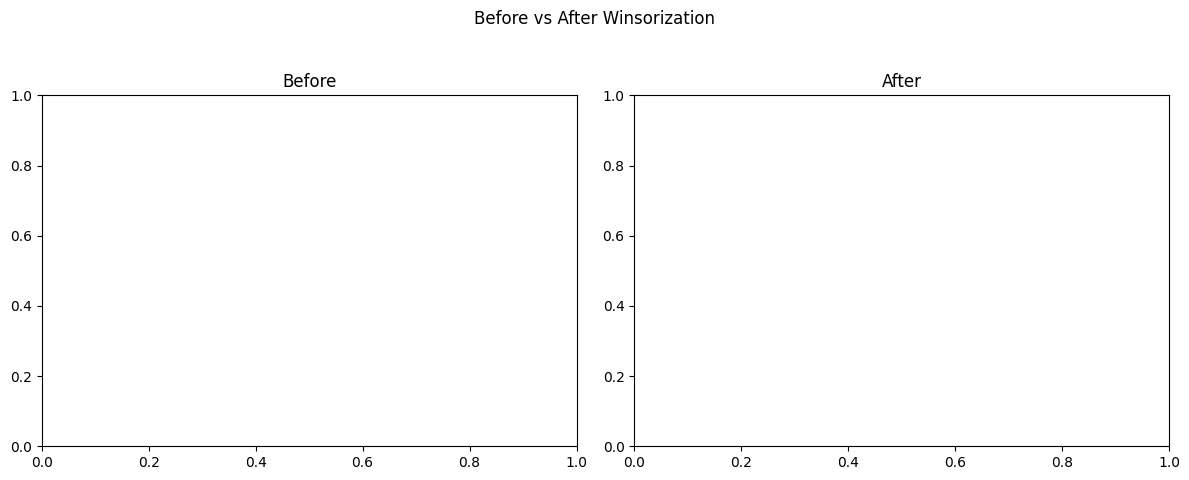

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Before vs After Winsorization")

sns.boxplot(sales = before, ax=axes[0])
axes[0].set_title("Before")

sns.boxplot(sales = after, ax=axes[1])
axes[1].set_title("After")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Bonus: Pandas Profiling

In [31]:
from ydata_profiling import ProfileReport

profile = ProfileReport(sales, title="EDA Report")
profile.to_file("eda_report.html")

c:\Users\BAPS\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Summarize dataset:  19%|█▉        | 3/16 [00:00<00:00, 15.05it/s, Describe variable: year] c:\Users\BAPS\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\BAPS\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
Summarize dataset:  25%|██▌       | 4/16 [00:00<00:00, 15.05it/s, Describe variable: sqrt_amount]c:\Users\BAPS\AppData\Local\Programs\Python\Python313\Lib\site-pa

# **SUMMARY REPORT**

# Data Cleaning, Transformation & Feature Engineering Report
## Objective

The objective of this project was to integrate data from multiple sources (Excel, JSON, and SQL), clean and preprocess the data, handle missing values and outliers, apply transformations and scaling, engineer meaningful features, and prepare a final dataset suitable for analysis and modeling.

# Data Understanding

Data was collected from three heterogeneous sources:

Users data (Excel) – customer demographic details

Sales data (JSON) – transactional purchase records

Inventory data (SQL) – product-related information

Initial exploration using head(), info(), and describe() revealed missing values, inconsistent data types, skewed numerical distributions, and outliers.

# Missing Value Handling

Numerical columns were imputed using mean imputation to preserve overall distribution.

Categorical columns were imputed using the most frequent value to maintain category consistency.

KNN Imputer was applied on transactional numerical data to leverage multivariate relationships.

This significantly reduced data sparsity without losing records.

# Outlier Detection & Treatment

Two methods were evaluated:

Z-Score Method – effective for normally distributed data.

IQR Method – more robust for skewed real-world business data.

The IQR method was selected due to heavy skewness in sales data.
For extreme but valid values, Winsorization was applied instead of removal to avoid loss of information.

# Data Transformation

Date columns were decomposed into day, month, and year.

Categorical variables were encoded using:

Label Encoding for binary features

One-Hot Encoding for nominal features

Log and square-root transformations were applied to reduce skewness in monetary columns.

Binning was used to segment customers into spending categories.

# Feature Scaling

Both StandardScaler and MinMaxScaler were applied to numerical features.
Standard scaling was preferred for model readiness due to variance normalization.

# Feature Engineering

New features were created to enhance analytical value:

Average monthly spend per customer

Purchase frequency

Total customer spend

Days since last purchase

These features improved customer behavior representation.

# Final Dataset

After merging all cleaned and engineered datasets:

Missing values were reduced significantly

Outliers were controlled

New informative features were added

The final dataset was saved as final_cleaned_dataset.csv and is ready for modeling and visualization.